In [122]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.datasets import make_blobs, make_moons
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

# <font color = 'red'> ЛР9. Бэггинг и случайные леса </font>

Сложность: <font color = 'Orange'> Средне  </font>.

Дата составления: 12.12.2023

Срок выполнения: 1 неделя (с момента первой практики после выдачи).

Автор: ст. преподаватель Кушнеров А.В.

## Задание 1.

Используя пример из документации,  изучите разложение ошибки в модели регрессии и влияние на неё бэггинга. 
Реализуйте пример. 
Предствьте краткие выводы в текстовой ячейке.  

https://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


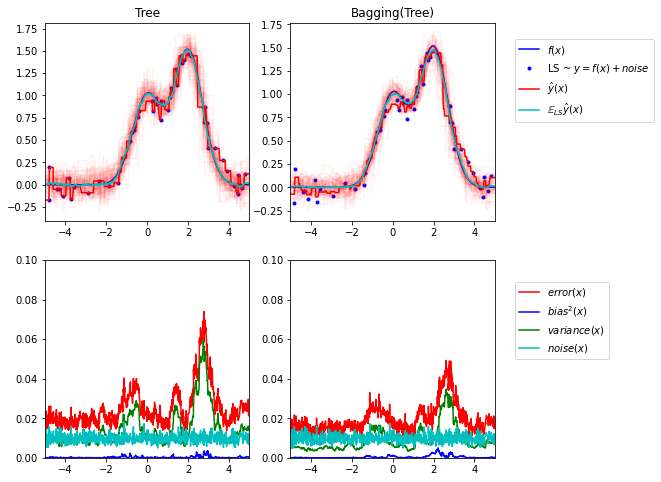

In [89]:
# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50  # Number of iterations for computing expectations
n_train = 50  # Size of the training set
n_test = 1000  # Size of the test set
noise = 0.1  # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [
    ("Tree", DecisionTreeRegressor()),
    ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor())),
]

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-(x**2)) + 1.5 * np.exp(-((x - 2) ** 2))


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= n_repeat * n_repeat

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print(
        "{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
        " + {3:.4f} (var) + {4:.4f} (noise)".format(
            name, np.mean(y_error), np.mean(y_bias), np.mean(y_var), np.mean(y_noise)
        )
    )

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c", label=r"$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, 0.5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, 0.5))

plt.subplots_adjust(right=0.75)
plt.show()

Ошибка на новых данных состоит из шума, смещения и разброса. Шум характеризует ошибку идеального алгоритма, им никак нельзя управлять. Смещение - отклонение среднего ответа обученного алгоритма от ответа идеального алгоритма. Разброс - разброс ответов обученных алгоритмов относительно среднего ответа (вариативность ответов модели).

При усреднении алгоритмов смещение не меняется, разброс уменьшается. 

Разброс = $\frac{разброс базового алгоритма}{N}$ + корреляция между базовыми алгоритмами.

Корреляцию можно уменьшить с помощью:

* бэггинга (обучение базовых алгоритмов на случайной подвыборке)

* метод случайных подпространств (обучение базовых алгоритмов на случайном подмножестве признаков)


Бэггинг сокращает дисперсию (variance) и улучшает обобщающую способность модели. 

## Задание 2. 

Для каждого из подзаданий:

1. Проведите предварительную обработку данных.
2. Постройте модель регрессии на основе метода дерева решений, бэггинга с деревом решений, случайного леса. 
3. Постройте модель регрессии на основе метода ближйших соседей, бэггинга ближйших соседей. 
4. Графически изобразите результаты классификации. 
5. Подберите оптимальные гиперпараметры модели используя различные оценки.
6. Сделайте выводы о точности моделей. Сравниете результаты для моделей из пункта 2-3. 
7. Обязательно в одном из заданий реализуйте прроцедуру бэггинга без встроенных решений.


### 2.1 Погодные условия во время второй мировой

https://www.kaggle.com/datasets/smid80/weatherww2/data

In [256]:
weather_data = pd.read_csv('Summary of Weather.csv')
locations = pd.read_csv('Weather Station Locations.csv')

C:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (7,8,18,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [257]:
weather_data.head()

,STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,...,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
0,10001,1942-7-1,1.016,NaN,25.555556,22.222222,23.888889,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,1942-7-2,0,NaN,28.888889,21.666667,25.555556,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,1942-7-3,2.54,NaN,26.111111,22.222222,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001,1942-7-4,2.54,NaN,26.666667,22.222222,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001,1942-7-5,0,NaN,26.666667,21.666667,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [258]:
locations

,WBAN,NAME,STATE/COUNTRY ID,LAT,LON,ELEV,Latitude,Longitude
0,33013,AIN EL,AL,3623N,00637E,611,36.383333,6.650000
1,33031,LA SENIA,AL,3537N,00037E,88,35.616667,0.583333
2,33023,MAISON BLANCHE,AL,3643N,00314E,23,36.716667,3.216667
3,33044,TELERGMA,AL,3607N,00621E,754,36.116667,6.416667
4,12001,TINDOUF,AL,2741N,00809W,443,27.683333,-8.083333
...,...,...,...,...,...,...,...,...
156,33109,EL AQUINA,TS,3651N,01015E,4,36.850000,10.016667
157,33121,EL DJEM,TS,3520N,01040E,9999,35.333333,10.066667
158,33003,SISI AHMED,TS,3712N,00950E,4,37.200000,9.083333
159,33307,ADANA,TU,3659N,03518E,20,36.983333,35.016667


In [259]:
to_drop = ['Precip', 'STA', 'Date', 'WindGustSpd', 'Snowfall', 'PoorWeather', 'PRCP', 'DR', 'SPD', 'SNF', 'SND', 'FT', 'FB', 'FTI', 'ITH', 'PGT', 'TSHDSBRSGF', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE']
weather_data.drop(to_drop, inplace=True, axis=1)

In [260]:
weather_data

,MaxTemp,MinTemp,MeanTemp,YR,MO,DA,MAX,MIN,MEA
0,25.555556,22.222222,23.888889,42,7,1,78.0,72.0,75.0
1,28.888889,21.666667,25.555556,42,7,2,84.0,71.0,78.0
2,26.111111,22.222222,24.444444,42,7,3,79.0,72.0,76.0
3,26.666667,22.222222,24.444444,42,7,4,80.0,72.0,76.0
4,26.666667,21.666667,24.444444,42,7,5,80.0,71.0,76.0
...,...,...,...,...,...,...,...,...,...
119035,28.333333,18.333333,23.333333,45,12,27,83.0,65.0,74.0
119036,29.444444,18.333333,23.888889,45,12,28,85.0,65.0,75.0
119037,28.333333,18.333333,23.333333,45,12,29,83.0,65.0,74.0
119038,28.333333,18.333333,23.333333,45,12,30,83.0,65.0,74.0


In [261]:
weather_data.isna().sum()

MaxTemp       0
MinTemp       0
MeanTemp      0
YR            0
MO            0
DA            0
MAX         474
MIN         468
MEA         498
dtype: int64

In [262]:
weather_data.dropna(subset=['MaxTemp', 'MinTemp', 'MeanTemp', 'MAX', 'MIN', 'MEA'], inplace=True)

In [263]:
weather_data.isna().sum()

MaxTemp     0
MinTemp     0
MeanTemp    0
YR          0
MO          0
DA          0
MAX         0
MIN         0
MEA         0
dtype: int64

In [264]:
weather_data

,MaxTemp,MinTemp,MeanTemp,YR,MO,DA,MAX,MIN,MEA
0,25.555556,22.222222,23.888889,42,7,1,78.0,72.0,75.0
1,28.888889,21.666667,25.555556,42,7,2,84.0,71.0,78.0
2,26.111111,22.222222,24.444444,42,7,3,79.0,72.0,76.0
3,26.666667,22.222222,24.444444,42,7,4,80.0,72.0,76.0
4,26.666667,21.666667,24.444444,42,7,5,80.0,71.0,76.0
...,...,...,...,...,...,...,...,...,...
119035,28.333333,18.333333,23.333333,45,12,27,83.0,65.0,74.0
119036,29.444444,18.333333,23.888889,45,12,28,85.0,65.0,75.0
119037,28.333333,18.333333,23.333333,45,12,29,83.0,65.0,74.0
119038,28.333333,18.333333,23.333333,45,12,30,83.0,65.0,74.0


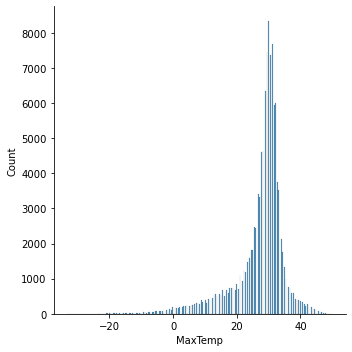

In [23]:
sns.displot(weather_data['MaxTemp'], kde=False)
plt.show()

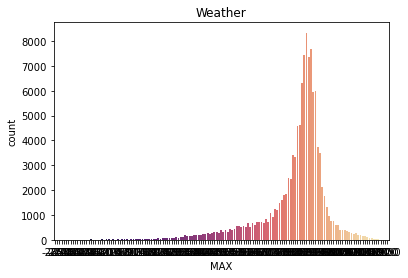

In [24]:
sns.countplot(x='MAX', data=weather_data, palette='magma')
plt.title('Weather')
plt.show()

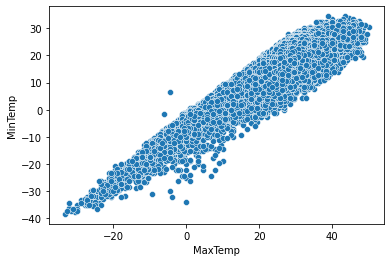

In [25]:
sns.scatterplot(x='MaxTemp', y='MinTemp', data=weather_data)
plt.show()

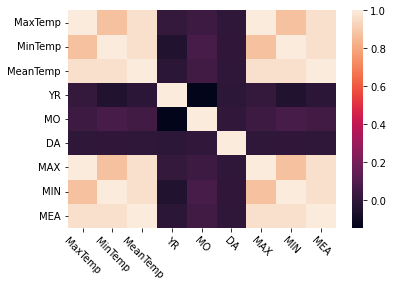

In [35]:
sns.heatmap(weather_data.corr())
plt.xticks(rotation=-45)
plt.show()

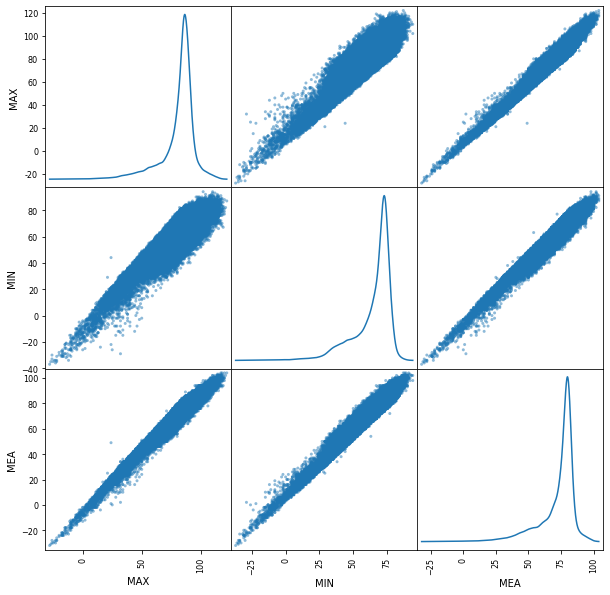

In [36]:
cols = ['MAX', 'MIN', 'MEA']
pd.plotting.scatter_matrix(weather_data[cols], figsize=(10, 10), diagonal='kde')
plt.show()


In [37]:
weather_data['MaxTemp']

0         25.555556
1         28.888889
2         26.111111
3         26.666667
4         26.666667
            ...    
119035    28.333333
119036    29.444444
119037    28.333333
119038    28.333333
119039    29.444444
Name: MaxTemp, Length: 118540, dtype: float64

In [42]:
weather_data[['MinTemp']]

,MinTemp
0,22.222222
1,21.666667
2,22.222222
3,22.222222
4,21.666667
...,...
119035,18.333333
119036,18.333333
119037,18.333333
119038,18.333333


In [43]:
weather_data['MinTemp']


0         22.222222
1         21.666667
2         22.222222
3         22.222222
4         21.666667
            ...    
119035    18.333333
119036    18.333333
119037    18.333333
119038    18.333333
119039    17.222222
Name: MinTemp, Length: 118540, dtype: float64

In [265]:
weather_data

,MaxTemp,MinTemp,MeanTemp,YR,MO,DA,MAX,MIN,MEA
0,25.555556,22.222222,23.888889,42,7,1,78.0,72.0,75.0
1,28.888889,21.666667,25.555556,42,7,2,84.0,71.0,78.0
2,26.111111,22.222222,24.444444,42,7,3,79.0,72.0,76.0
3,26.666667,22.222222,24.444444,42,7,4,80.0,72.0,76.0
4,26.666667,21.666667,24.444444,42,7,5,80.0,71.0,76.0
...,...,...,...,...,...,...,...,...,...
119035,28.333333,18.333333,23.333333,45,12,27,83.0,65.0,74.0
119036,29.444444,18.333333,23.888889,45,12,28,85.0,65.0,75.0
119037,28.333333,18.333333,23.333333,45,12,29,83.0,65.0,74.0
119038,28.333333,18.333333,23.333333,45,12,30,83.0,65.0,74.0


In [316]:
X = weather_data[['YR', 'MO', 'DA', 'MAX', 'MIN', 'MEA']]
y = weather_data[['MeanTemp']] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [317]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test= scaler.fit_transform(X_test)

### Дерево

In [318]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [319]:
y_pred_tree = tree_reg.predict(X_test)

In [320]:
mse_tree = mean_squared_error(y_test, tree_reg.predict(X_test))
mse_tree

3.905542089246327e-05

In [321]:
r2_tree = r2_score(y_test, tree_reg.predict(X_test))

In [322]:
print("Random Forest RMSE Score: {:.2f}".format(mse_tree))
print("Random Forest R2 Score: {:.2f}".format(r2_tree))

Random Forest RMSE Score: 0.00
Random Forest R2 Score: 1.00


In [323]:
y_test.to_numpy()[ind].shape

(100, 1)

In [324]:
y_pred_tree[ind].shape

(100,)

In [325]:
tree_reg.predict(X_test)[0]

19.444444440000005

In [326]:
ind = np.random.choice(len(X_test), 100)
ind.shape

(100,)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(100), y_test, range(100), tree_reg.predict(X_test))

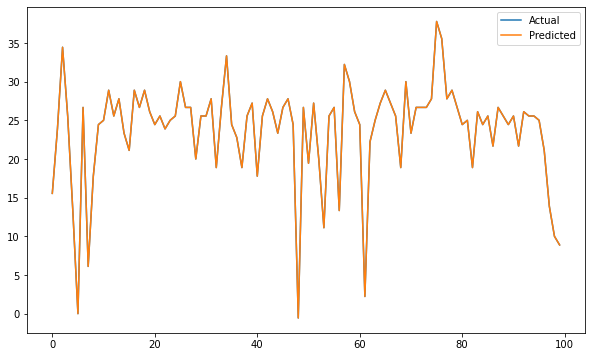

In [336]:
ind = np.random.choice(len(X_test), 100)

plt.figure(figsize=(10, 6))
plt.plot(range(100), y_test.to_numpy()[ind], label='Actual')
plt.plot(range(100), tree_reg.predict(X_test[ind]), label='Predicted')

plt.legend()
plt.show()


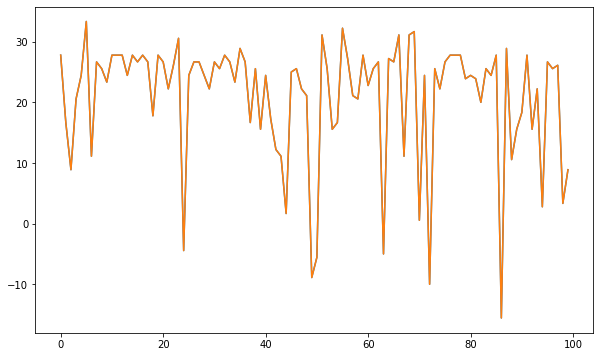

In [335]:
ind = np.random.choice(len(X_test), 100)

plt.figure(figsize=(10, 6))
plt.plot(range(100), tree_reg.predict(X_test[ind]), range(100), y_test.to_numpy()[ind])

### Бэггинг с деревом

In [338]:
bagging_reg = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=5, random_state=42)
bagging_reg.fit(X_train, y_train)


C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=5,
                 random_state=42)

### Случайный лес

In [339]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

In [340]:
rf_reg.fit(X_train, y_train)

C:\Users\user\AppData\Local\Temp/ipykernel_17528/3901435218.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [341]:
rmse_rf = mean_squared_error(y_test,  rf_reg.predict(X_test))

In [342]:
r2_rf = r2_score(y_test,  rf_reg.predict(X_test))

In [343]:
print("Random Forest RMSE Score: {:.2f}".format(rmse_rf))
print("Random Forest R2 Score: {:.2f}".format(r2_rf))

Random Forest RMSE Score: 0.00
Random Forest R2 Score: 1.00


In [344]:
 y_pred_rf = rf_reg.predict(X_test)

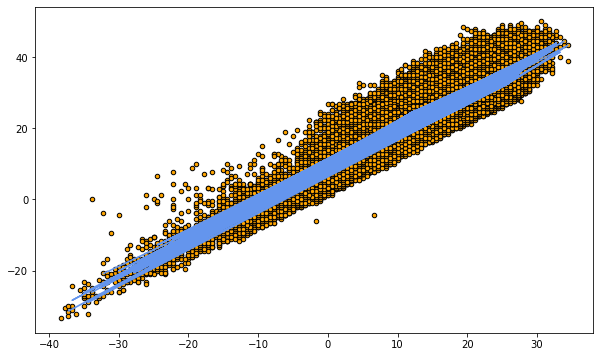

In [160]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, s=20, edgecolor="black", c="orange", label="data")
plt.plot(X_test, y_pred_tree, color="cornflowerblue", label="tree (MSE={:.2f})".format(mse_tree))

### Метод боижайших соседей

In [345]:
from sklearn.neighbors import KNeighborsRegressor

In [346]:
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)

KNeighborsRegressor()

In [347]:
param_grid = {'n_neighbors': [1, 3, 5, 7, 10]}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best KNN Parameters:", grid_search.best_params_)

Best KNN Parameters: {'n_neighbors': 7}


In [348]:
knn_best = grid_search.best_estimator_
y_knn_best = knn_best.predict(X_test)
mse_knn_best = mean_squared_error(y_test, y_knn_best)
print("Mean Squared Error (KNN Best):", mse_knn_best)

Mean Squared Error (KNN Best): 0.0967006915198484


### Бэгинг ближайших соседей

In [349]:
bagging_knn_reg = BaggingRegressor(base_estimator=KNeighborsRegressor(n_neighbors = 50), n_estimators=10, random_state=42)
bagging_knn_reg.fit(X_train, y_train)


C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


BaggingRegressor(base_estimator=KNeighborsRegressor(n_neighbors=50),
                 random_state=42)

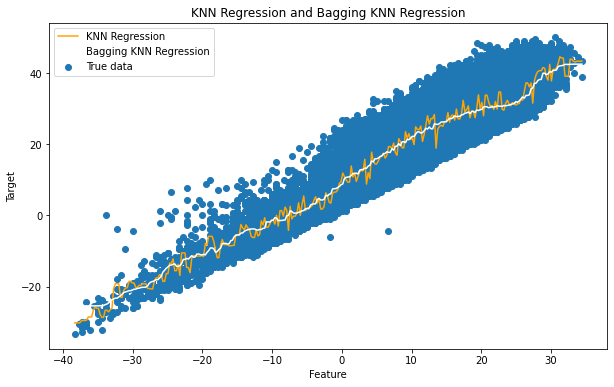

In [195]:
x_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
y_knn = knn_reg.predict(x_range)
y_bagging_knn = bagging_knn_reg.predict(x_range)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='True data')
plt.plot(x_range, y_knn, label='KNN Regression', color='orange')
plt.plot(x_range, y_bagging_knn, label='Bagging KNN Regression', color='white')
plt.title('KNN Regression and Bagging KNN Regression')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.legend()
plt.show()

## Задание 3. 

Для каждого из подзаданий:

1. Проведите предварительную обработку данных.
2. Постройте модель регресси на основе метода дерева решений, бэггинга с деревом решений, случайного леса. 
3. Постройте модель регресси на основе метода ближйших соседей, бэггинга ближйших соседей. 
4. Графически изобразите результаты классификации. 
5. Подберите оптимальные гиперпараметры модели используя различные оценки.
6. Сделайте выводы о точности моделей. Сравниете результаты для моделей из пункта 2-3. 
7. Постройте валидационные кривые.


### 3.1 Скоринг отказа от услуг оператора связи.

Используйте данные из файла telecom.csv для предсказания отказа от услуг связи. Столбец "churn". 
Предврительно изучите и подготовьте данные.

In [202]:
telecom = pd.read_csv('telecom_output.csv')

In [203]:
telecom

,account length,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls,churn
0,128,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,107,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,137,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,84,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,75,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,36,156.2,77,215.5,126,279.1,83,9.9,6,2,0
3329,68,0,231.1,57,153.4,55,191.3,123,9.6,4,3,0
3330,28,0,180.8,109,288.8,58,191.9,91,14.1,6,2,0
3331,184,0,213.8,105,159.6,84,139.2,137,5.0,10,2,0


In [204]:
X, y = telecom.drop(['churn'], axis=1), telecom['churn']

scaler = StandardScaler()

X_std = scaler.fit_transform(X)
poly = PolynomialFeatures(degree=2) 
X_std_poly2 = poly.fit_transform(X_std)

X_std_poly2.shape

(3333, 78)

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
random_state=42)

### Дерево

In [206]:
tree = DecisionTreeClassifier()
parameters = {'min_samples_leaf': range(1, 10),'max_depth': range(1, 10)}
clf = GridSearchCV(tree, parameters, cv=5, scoring='f1_weighted', return_train_score=True)
clf.fit(X_train, y_train)
results = clf.cv_results_

In [207]:
best_params = clf.best_params_
best_score = clf.best_score_
print(best_params, best_score)

{'max_depth': 5, 'min_samples_leaf': 4} 0.8989283896872028


In [208]:
tree = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 4)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

In [209]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Precision: 0.8481012658227848
Recall: 0.46853146853146854


In [210]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       857
           1       0.85      0.47      0.60       143

    accuracy                           0.91      1000
   macro avg       0.88      0.73      0.78      1000
weighted avg       0.91      0.91      0.90      1000



In [223]:
mse_tree = mean_squared_error(y_test, tree.predict(X_test))
mse_tree

0.088

In [224]:
r2_tree = r2_score(y_test, tree.predict(X_test))

In [225]:
print("Random Forest RMSE Score: {:.2f}".format(mse_tree))
print("Random Forest R2 Score: {:.2f}".format(r2_tree))

Random Forest RMSE Score: 0.09
Random Forest R2 Score: 0.28


### Бэггинг с деревом

In [216]:
bagging_reg = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=5, random_state=42)
bagging_reg.fit(X_train, y_train)


BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=5,
                 random_state=42)

In [219]:
y_bagging = bagging_reg.predict(X_test)

In [228]:
mse_bag = mean_squared_error(y_test, bagging_reg.predict(X_test))
mse_bag

0.08292000000000002

In [229]:
r2_bag = r2_score(y_test, bagging_reg.predict(X_test))

In [230]:
print("Random Forest RMSE Score: {:.2f}".format(mse_bag))
print("Random Forest R2 Score: {:.2f}".format(r2_bag))

Random Forest RMSE Score: 0.08
Random Forest R2 Score: 0.32


### Случайный лес

In [231]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

In [232]:
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [233]:
rmse_rf = mean_squared_error(y_test,  rf_reg.predict(X_test))

In [234]:
r2_rf = r2_score(y_test,  rf_reg.predict(X_test))

In [235]:
print("Random Forest RMSE Score: {:.2f}".format(rmse_rf))
print("Random Forest R2 Score: {:.2f}".format(r2_rf))

Random Forest RMSE Score: 0.06
Random Forest R2 Score: 0.49


In [236]:
 y_pred_rf = rf_reg.predict(X_test)

### Метод боижайших соседей

In [238]:
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)

KNeighborsRegressor()

In [239]:
param_grid = {'n_neighbors': [1, 3, 5, 7, 10]}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best KNN Parameters:", grid_search.best_params_)

Best KNN Parameters: {'n_neighbors': 10}


In [240]:
knn_best = grid_search.best_estimator_
y_knn_best = knn_best.predict(X_test)
mse_knn_best = mean_squared_error(y_test, y_knn_best)
print("Mean Squared Error (KNN Best):", mse_knn_best)

Mean Squared Error (KNN Best): 0.09724000000000001


### Бэгинг ближайших соседей

In [241]:
bagging_knn_reg = BaggingRegressor(base_estimator=KNeighborsRegressor(n_neighbors = 50), n_estimators=10, random_state=42)
bagging_knn_reg.fit(X_train, y_train)


BaggingRegressor(base_estimator=KNeighborsRegressor(n_neighbors=50),
                 random_state=42)

### 3.2 Предсказание диабета у пациентов.

Используйте данные из файла diabetes.csv для предсказания исхода для пациентов. Столбец "outcome". Предварительно изучите и подготовьте данные. 

In [298]:
diabet = pd.read_csv('diabetes.csv')

In [299]:
X, y = diabet.drop(['Outcome'], axis=1), diabet['Outcome']

scaler = StandardScaler()

X_std = scaler.fit_transform(X)
poly = PolynomialFeatures(degree=2) 
X_std_poly2 = poly.fit_transform(X_std)

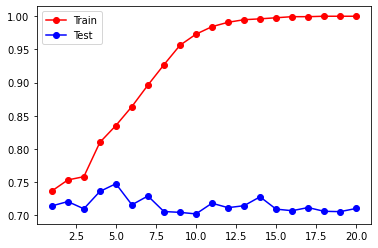

In [301]:
tree = DecisionTreeClassifier()
parameters = {'max_depth': range(1, 21)}
clf = GridSearchCV(tree, parameters, cv=5, scoring='f1_weighted', return_train_score=True)
clf.fit(X, y)
results = clf.cv_results_

plt.plot(range(1, 21), results['mean_train_score'], 'r-o')
plt.plot(range(1, 21), results['mean_test_score'], 'b-o')

plt.legend(['Train', 'Test'])

plt.show()

In [172]:
best_params = clf.best_params_
best_score = clf.best_score_
print(best_params, best_score)

{'max_depth': 5} 0.746518812662455


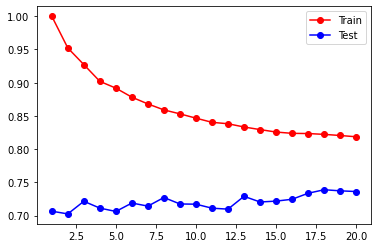

In [173]:
tree = DecisionTreeClassifier()
parameters = {'min_samples_leaf': range(1, 21)}
clf = GridSearchCV(tree, parameters, cv=5, scoring='f1_weighted', return_train_score=True)
clf.fit(X, y)
results = clf.cv_results_

plt.plot(range(1, 21), results['mean_train_score'], 'r-o')
plt.plot(range(1, 21), results['mean_test_score'], 'b-o')

plt.legend(['Train', 'Test'])

plt.show()

In [174]:
best_params = clf.best_params_
best_score = clf.best_score_
print(best_params, best_score)

{'min_samples_leaf': 18} 0.7388569059378055


In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
random_state=42)

In [177]:
tree = DecisionTreeClassifier()
parameters = {'min_samples_leaf': range(1, 21),'max_depth': range(1, 21)}
clf = GridSearchCV(tree, parameters, cv=5, scoring='f1_weighted', return_train_score=True)
clf.fit(X_train, y_train)
results = clf.cv_results_

In [178]:
best_params = clf.best_params_
best_score = clf.best_score_
print(best_params, best_score)

{'max_depth': 9, 'min_samples_leaf': 9} 0.7512523261496068


In [180]:
tree = DecisionTreeClassifier(max_depth = 9, min_samples_leaf = 9)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

In [181]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Precision: 0.5567010309278351
Recall: 0.675


In [89]:
from sklearn.metrics import classification_report

In [184]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.72      0.76       151
           1       0.56      0.68      0.61        80

    accuracy                           0.70       231
   macro avg       0.68      0.70      0.68       231
weighted avg       0.72      0.70      0.71       231



### 3.3 Расознавание рукописных цифр.

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()

## Ссылки

https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/

https://towardsdatascience.com/understanding-random-forest-58381e0602d2

https://medium.com/swlh/random-forest-and-its-implementation-71824ced454f